# Projet : Detection d’Anomalies dans le Trafic Reseau avec LightGBM

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

In [20]:
df = pd.read_csv('data-20221207.csv')

In [21]:
df.shape

(35250, 84)

Dans notre analyse pour detecter les anomalies, nous remarquons que les adresses IP, les ports et les protocoles n'ont pas une importance signifigative sur notre travail. Et, nous allons supprimer tous les variables qui sont tous de types objects.

Pour continuer notre travail et faire du lightGBM, nous allons l'associer avec du IsolationForest pour avoir de bons resultats.

In [24]:
df_clean = df.drop(columns=df.select_dtypes(include=["object"]).columns)

# Détection d'anomalies avec Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_clean['anomaly_score'] = iso_forest.fit_predict(df_clean)

# Création des labels artificiels (1 = anomalie, 0 = normal)
df['Label'] = (df_clean['anomaly_score'] == -1).astype(int)

In [25]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.20.19-54.77.51.148-33118-80-6,192.168.20.19,33118,54.77.51.148,80,6,06/12/2022 11:00:15 PM,36728,5,3,...,20,0,0,0,0,1.670368e+15,1.428227e+04,1.670368e+15,1.670368e+15,1
1,192.168.20.48-108.137.181.26-53948-443-6,192.168.20.48,53948,108.137.181.26,443,6,06/12/2022 11:00:51 PM,890408,17,16,...,32,0,0,0,0,1.670368e+15,1.818134e+05,1.670368e+15,1.670368e+15,0
2,192.168.20.43-34.232.93.236-58752-443-6,192.168.20.43,58752,34.232.93.236,443,6,06/12/2022 11:01:19 PM,3777984,13,13,...,32,0,0,0,0,1.670368e+15,3.286600e+05,1.670368e+15,1.670368e+15,1
3,192.168.20.43-54.70.5.180-46084-443-6,192.168.20.43,46084,54.70.5.180,443,6,06/12/2022 11:01:25 PM,8672390,17,16,...,32,0,0,0,0,1.670368e+15,1.159272e+06,1.670368e+15,1.670368e+15,0
4,192.168.20.15-255.255.255.255-49156-6666-17,192.168.20.15,49156,255.255.255.255,6666,17,06/12/2022 11:00:02 PM,116995737,40,0,...,8,0,0,0,0,1.670368e+15,3.333902e+07,1.670368e+15,1.670368e+15,0


<Axes: >

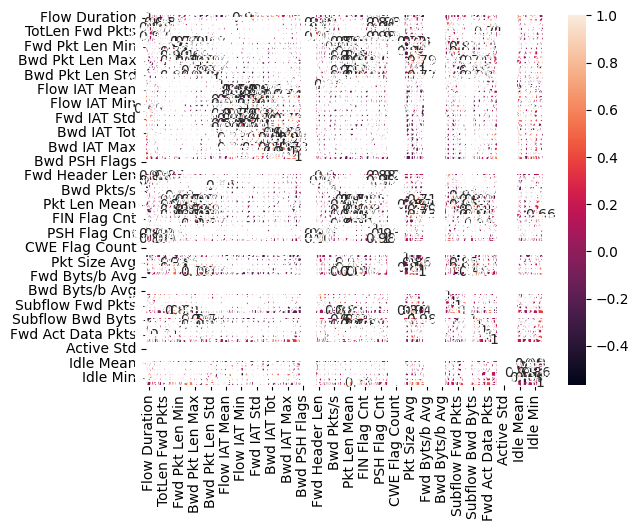

In [19]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35250 entries, 0 to 35249
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            35250 non-null  object 
 1   Src IP             35250 non-null  object 
 2   Src Port           35250 non-null  int64  
 3   Dst IP             35250 non-null  object 
 4   Dst Port           35250 non-null  int64  
 5   Protocol           35250 non-null  int64  
 6   Timestamp          35250 non-null  object 
 7   Flow Duration      35250 non-null  int64  
 8   Tot Fwd Pkts       35250 non-null  int64  
 9   Tot Bwd Pkts       35250 non-null  int64  
 10  TotLen Fwd Pkts    35250 non-null  float64
 11  TotLen Bwd Pkts    35250 non-null  float64
 12  Fwd Pkt Len Max    35250 non-null  float64
 13  Fwd Pkt Len Min    35250 non-null  float64
 14  Fwd Pkt Len Mean   35250 non-null  float64
 15  Fwd Pkt Len Std    35250 non-null  float64
 16  Bwd Pkt Len Max    352

In [12]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.20.19-54.77.51.148-33118-80-6,192.168.20.19,33118,54.77.51.148,80,6,06/12/2022 11:00:15 PM,36728,5,3,...,20,0,0,0,0,1.670368e+15,1.428227e+04,1.670368e+15,1.670368e+15,1
1,192.168.20.48-108.137.181.26-53948-443-6,192.168.20.48,53948,108.137.181.26,443,6,06/12/2022 11:00:51 PM,890408,17,16,...,32,0,0,0,0,1.670368e+15,1.818134e+05,1.670368e+15,1.670368e+15,0
2,192.168.20.43-34.232.93.236-58752-443-6,192.168.20.43,58752,34.232.93.236,443,6,06/12/2022 11:01:19 PM,3777984,13,13,...,32,0,0,0,0,1.670368e+15,3.286600e+05,1.670368e+15,1.670368e+15,1
3,192.168.20.43-54.70.5.180-46084-443-6,192.168.20.43,46084,54.70.5.180,443,6,06/12/2022 11:01:25 PM,8672390,17,16,...,32,0,0,0,0,1.670368e+15,1.159272e+06,1.670368e+15,1.670368e+15,0
4,192.168.20.15-255.255.255.255-49156-6666-17,192.168.20.15,49156,255.255.255.255,6666,17,06/12/2022 11:00:02 PM,116995737,40,0,...,8,0,0,0,0,1.670368e+15,3.333902e+07,1.670368e+15,1.670368e+15,0


In [13]:
df['Label'].value_counts()

Label
0    33487
1     1763
Name: count, dtype: int64

In [27]:
class DataPreprocessor:
    """
    Prétraitement des Données

    • Nettoyage : Imputer les valeurs manquantes.
    • Encodage des variables catégorielles : Appliquer l’encodage par variables factices (dummy variables)
      pour les données non numériques.
    • Standardisation : Standardiser les données numériques pour améliorer les performances des algorithmes.
    • Livrable : Code et documentation du pipeline de prétraitement des données.

    Attributes:
    -----------
    df : pd.DataFrame
        Le DataFrame contenant les données à traiter.
    target_column : str
        La colonne cible pour le modèle.
    exclude_columns : list
        Les colonnes à exclure du prétraitement (par défaut, aucune colonne n'est exclue).
    test_size : float
        La proportion de l'ensemble de test (par défaut, 0.2).
    random_state : int
        Graine aléatoire pour la reproductibilité du découpage en train/test (par défaut, 0).
    """
    
    def __init__(self, df, target_column, exclude_columns=None, test_size=0.2, random_state=0):
        
        self.df = df
        self.target_column = target_column
        self.exclude_columns = exclude_columns if exclude_columns is not None else []
        self.test_size = test_size
        self.random_state = random_state


    def impute_outliers(self, colname): 
        q1 = np.percentile(self.df[colname], 25)
        q3 = np.percentile(self.df[colname], 75) 

        lower_bound = q1 - 1.5*(q3 - q1)
        upper_bound = q3 + 1.5*(q3 - q1)

        self.df.loc[(self.df[colname] <= lower_bound), colname] = lower_bound
        self.df.loc[(self.df[colname] >= upper_bound), colname] = upper_bound

    def preprocess_data(self):
        """
        Impute les valeurs aberrantes pour toutes les colonnes numériques.
        """
        for colname in self.df.select_dtypes('number').columns:
            self.impute_outliers(colname)
        

    def split_data(self):
        """
        Divise les données en ensembles d'entraînement et de test.

        Returns:
        --------
        X_train, X_test, y_train, y_test : tuple
            Données divisées en ensembles d'entraînement et de test.
        """
        y = self.df[self.target_column]
        X = self.df.drop([self.target_column] + self.exclude_columns, axis='columns')
        
        X_train, X_test, y_train, y_test = train_test_split(
                                 X, 
                                 y, 
                                 test_size=self.test_size, 
                                 random_state=self.random_state
                            )
        return X_train, X_test, y_train, y_test
    
    

    def create_pipeline(self, X_train):
        """
        Crée un pipeline de prétraitement pour les données.

        Étapes du pipeline :
        - Imputation des valeurs manquantes.
        - Standardisation des colonnes numériques.
        - Encodage des variables catégorielles avec des variables factices.

        Parameters:
        -----------
        X_train : pd.DataFrame
            Données d'entraînement pour déterminer les types de colonnes.

        Returns:
        --------
        full_pipeline : ColumnTransformer
            Pipeline de transformations pour le prétraitement complet des données.
        """
        num_cols = X_train.select_dtypes(include=['number']).columns
        cat_cols = X_train.select_dtypes(include='object').columns
        num_pipeline = make_pipeline(
                    SimpleImputer(strategy='median'),
                    StandardScaler(),
                )
        cat_pipeline = make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore', drop='first')
                )
        full_pipeline = ColumnTransformer([
                            ('num', num_pipeline, num_cols),
                            ('cat', cat_pipeline, cat_cols)
                        ])
        return full_pipeline

In [28]:
preprocessing = DataPreprocessor(df, 'Label',['Flow ID','Src IP','Src Port'	,'Dst IP','Dst Port','Protocol','Timestamp'],random_state=10)
X_train, X_test, y_train, y_test = preprocessing.split_data()
pipeline = preprocessing.create_pipeline(X_train)

In [29]:
X_train_transform = pipeline.fit_transform(X_train)
X_test_transform = pipeline.transform(X_test)

In [32]:
X_train_transform

array([[-1.20487772, -0.25028654, -0.03174658, ..., -0.23855485,
         0.68015839,  0.78769209],
       [ 1.25571459,  0.42112203, -0.03687107, ..., -0.23855466,
         0.68022169,  0.78775251],
       [ 1.11321494, -0.01675312, -0.00612413, ..., -0.23855466,
         0.68024006,  0.78777008],
       ...,
       [-1.20530666, -0.27947822, -0.03174658, ..., -0.23855485,
        -1.47018197, -1.26948604],
       [-1.20531421, -0.22109486, -0.03687107, ..., -0.23855485,
         0.6801355 ,  0.78767019],
       [-1.20306068, -0.25028654, -0.03687107, ..., -0.23855485,
        -1.47018197, -1.26948604]], shape=(28200, 76))